# Introduction: Home Credit Default Risk Competition

竞赛目的是通过贷款者的历史信贷信息来预测贷款者是否会违约。

数据来源于Home Credit，一家致力于向没有银行账户的人群提供信贷业务的公司。在日常的业务中，如何预测客户是否能够还贷或者是否有能力偿还贷款，是该公司业务发展过程中急需解决的痛点问题。本次Home Credit公司举办此竞赛，意在通过Kaggle上数据科学家开发优秀的机器学习模型，在此问题上给公司业务发展寄予帮助。

整个数据集由7部分组成：

* application_train/application_test: 训练集和测试集的主要部分，包含每一个客户在Home Credit公司的信贷申请表。每个客户都有专属于他的一行信息，唯一的身份认定id为字段**SK_ID_CURR**。训练集中的**TARGET**字段，0代表用户完成了还贷，1表示用户没有偿还贷款，违约。
* bureau: 该表中包含客户过去在其他金融机构的信贷信息。每一笔历史信贷信息都对应bureau中的一行，任意一位在application文件中的客户，可能在bureau文件中有多条历史信贷信息。
* bureau_balance: 对应bureau中信贷业务的每月的详细数据。每一行是过去信贷的一个月信息的汇总，每个信贷申请者可能有多条历史信贷信息。
* previous_application: 曾经在Home Credit办理过信贷业务的用户历史的申请表中的信息。每一个在application文件中现在的贷款者，可能在Home Credit已经办理过好几次贷款业务。每条历史贷款业务都有独立的一行信息，每行信息都有一个唯一的字段**SK_ID_PREV**来识别。
* POS_CASH_BALANCE: 用户过去每个月使用Home Credit刷信用卡消费的流水，每个用户可能有多条这样的刷卡消费信息。
* credit_card_balance: 使用Home Credit信用卡消费的用户的每月信用余额，每个单独的信用卡可能有多条数据信息。
* installments_payment: 历史在Home Credit上支付信息。

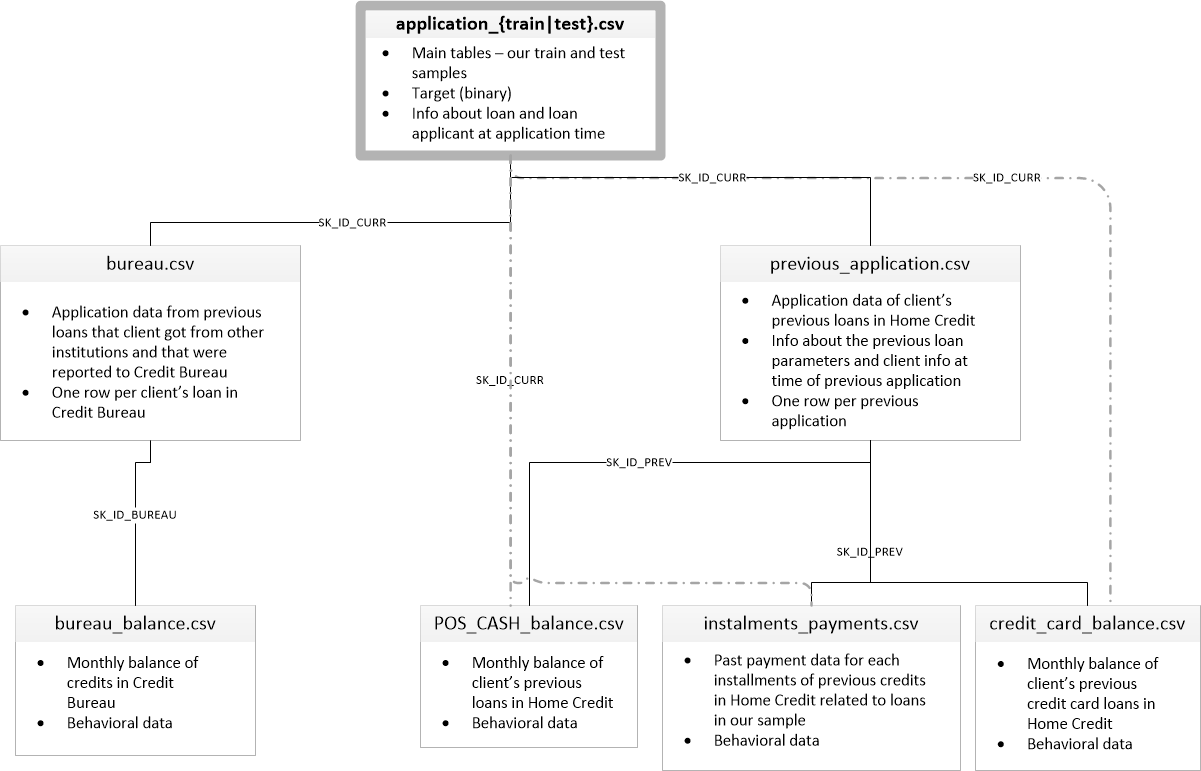

在这一部分中，仅讨论使用application中的数据信息。通过这部分的工作，建立起对本次竞赛题目的基本认识。后续为了提高模型预测效果，再讨论如何使用剩余的数据。

#### 评价指标：AUC

由于此次竞赛题的特殊性，违约用户在全部用户中占比显然是非常少的，分类不平衡的情况下，如果使用准确度accuracy并不是一个合理的指标。对于类别不平衡问题，AUC会是一个更为合理的评价指标。计算AUC值需要先得到ROC曲线，ROC曲线的横坐标是FPR假正率，纵坐标的TPR真正率。我们将预测为正类的样本概率从大到小排序，依次降序将这些概率设定为判断样本正负的threshold，得到一系列的FPR与TPR的点，由这些点连接绘制ROC曲线，ROC曲线下方围城的面积即为AUC值。

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import sys
import gc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
print(os.listdir("../data/"))

['all_engineered.csv', 'application_test.csv', 'application_train.csv', 'baseline_lgb.csv', 'bureau.csv', 'bureau_balance.csv', 'combin_lgb_submit.csv', 'credit_card_balance.csv', 'dnn_baseline.csv', 'dnn_baseline_engineered.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'lgb_submit.csv', 'log_reg_baseline.csv', 'log_reg_poly.csv', 'lr_submit.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'random_forest_baseline.csv', 'sample_submission.csv']


## 1 主表application.csv数据探索

### 1.1导入数据

In [3]:
app_train = pd.read_csv("../data/application_train.csv")
print("Training data shape: {}".format(app_train.shape))

Training data shape: (307511, 122)


In [4]:
display(app_train.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


训练集中包含307511条样本，每条对应一个独立的申请人，每条包含122列特征，也包括我们的预测变量TARGET。

In [5]:
app_test = pd.read_csv("../data/application_test.csv")
print("Testing data shape: {}".format(app_test.shape))

Testing data shape: (48744, 121)


In [6]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


把app_train和app_test拼接在一起处理

In [8]:
app = pd.concat([app_train,app_test],axis=0)
del app_train,app_test
gc.enable()
gc.collect()

21

### 1.2 数据探索分析

数据探索分析阶段是数据挖掘最初步也是比较重要的环节，可能过程会比较枯燥乏味，但是对于后续特征工程和建模而言，是非常必要的。通过数据探索分析，通过一些统计学和图表的方式找到数据中存在的趋势、异常、模式或者数据之间的关系。数据探索分析过程是一个高水平的总览性工作，我们可以在数据中挖掘一些感兴趣的部分。

#### 1.2.1TARGET的分布状况

In [9]:
count = app['TARGET'].value_counts()
print(count)
print(count/count.min())

0.0    282686
1.0     24825
Name: TARGET, dtype: int64
0.0    11.38715
1.0     1.00000
Name: TARGET, dtype: float64


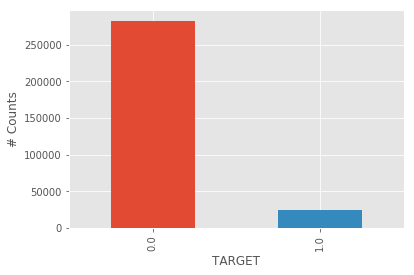

In [10]:
app['TARGET'].value_counts().plot(kind='bar')
plt.xlabel('TARGET')
plt.ylabel('# Counts')
plt.show()

从上述统计结果和图表所展示来看，我们面对的是一个类别不平衡的分类问题。大部分的贷款者都按时还贷，只有少部分的贷款者违约，正例与负例样本的比值达到1:11.4。处理类别不平衡分类问题的方法有很多：（1）上采样；（2）下采样；（3）人工构造少类样本；（4）代价敏感矩阵。

#### 1.2.2数据缺失状况

In [11]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_precent = 100*df.isnull().sum()/len(df)
    
    mis_val_table = pd.concat([mis_val,mis_val_precent],axis=1)
    
    mis_val_table_ren_columns = mis_val_table.rename(columns={0:'Missing Values',1:'% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]>0].sort_values('% of Total Values',ascending=False).round(1)
    
    print("Your selected dataframe has {} columns.".format(df.shape[1]))
    print("There are {} columns that have missing values.".format(mis_val_table_ren_columns.shape[0]))
    return mis_val_table_ren_columns

In [12]:
missing_values = missing_values_table(app)
display(missing_values.head(20))

Your selected dataframe has 122 columns.
There are 68 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,248360,69.7
COMMONAREA_MODE,248360,69.7
COMMONAREA_MEDI,248360,69.7
NONLIVINGAPARTMENTS_MODE,246861,69.3
NONLIVINGAPARTMENTS_MEDI,246861,69.3
NONLIVINGAPARTMENTS_AVG,246861,69.3
FONDKAPREMONT_MODE,243092,68.2
LIVINGAPARTMENTS_MODE,242979,68.2
LIVINGAPARTMENTS_MEDI,242979,68.2
LIVINGAPARTMENTS_AVG,242979,68.2


从上面展示的排名前20的缺失数据来看，数据缺失比例达到60%-70%。数据缺失会极大的影响建模预测结果，对于缺失数据过多的特征，一般会舍去这一列特征，而对于缺失并不是很严重的特征，可以考虑进行缺失值填补，比如使用均值、中位数、众数等策略，或者进行更加细致的分析，发现特征之间隐含的关系来进行填补；还有就是使用以树模型为基础的提升方法lightgbm，它能够在有数据缺失的情况下，仍然正常运行。

### 1.2.3数据类型及类别特征的编码

In [13]:
app.dtypes.value_counts()

float64    66
int64      40
object     16
dtype: int64

训练数据集中各个特征的数据类型分属3个大类，float64、int64和object，object可能是类别特征，也可能是字符串。

我们进一步查看一下，数据类型为object的列，每列都有几个唯一的取值。

In [14]:
app.select_dtypes('object').apply(lambda x: len(x.unique()),axis=0)

CODE_GENDER                    3
EMERGENCYSTATE_MODE            3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
NAME_CONTRACT_TYPE             2
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                8
OCCUPATION_TYPE               19
ORGANIZATION_TYPE             58
WALLSMATERIAL_MODE             8
WEEKDAY_APPR_PROCESS_START     7
dtype: int64

大部分的categorical特征只有少数几个取值，仅有**OCCUPATION_TYPE**和**ORGANIZATION_TYPE**所包含的类别会比较多。

#### Encoding Categorical Variables

大多数的机器学习模型都不能处理类别特征（除了极个别的模型，如LightGBM），一般都需要将类别特征先进行数字编码，转换为程序能够理解的信息进行后续建模。
* Label encoding
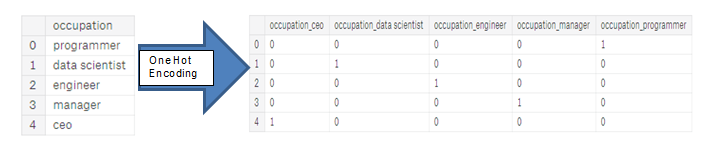
* One-hot encoding
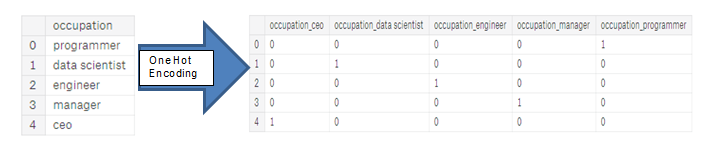

Label encoding会得到一个从0开始的顺序编码，对于那些有顺序含义的特征，比如问题描述，冷、温、热，用0,1,2来编码，这样的顺序意义是可以适用的，然而对于黄、绿、蓝这样不存在顺序意义的类别特征，用label encoding则不一定好。因为我们没法去界定黄与绿之间的距离为什么比黄与蓝之间的距离要近。这个时候就要使用到one-hot encoding，它将返回一个矩阵，矩阵的每一列代表原特征中的一个类别，该样本所属类别对应的列取值为1，其他均为0。
One-hot encoding也会有问题，当类别比较多的时候，返回的矩阵会非常稀疏，对于一些处理稀疏情况性能不好的模型是一个问题，后续会考虑使用embedding或者PCA之类的降维方法来处理。

#### Label Encoding and One-hot Encoding

对于只有2个类别的特征列使用Label Encoding，对于有两个以上类别的特征使用One-hot Encoding。

In [15]:
le = LabelEncoder()
le_counts = 0
for col in app.columns:
    if app[col].dtype == 'object':
        if len(app[col].unique()) <= 2:
            le.fit(app[col])
            app[col] = le.transform(app[col])
            le_counts += 1
print("{} columns were label encoded.".format(le_counts))

3 columns were label encoded.


使用pandas.get_dummise进行one_hot encoding

In [16]:
app = pd.get_dummies(app,prefix_sep='_')

In [17]:
print("App file Features shape: {}".format(app.shape))

App file Features shape: (356255, 243)


### 1.2.4 异常值

数据探索的一个目的之一是发现数据中的异常值，这些异常值的可能是由于数据录入人员误填、或者错看了单位等等。处理这类异常值的方法包括计算这一列特征的分位统计，或者之间画boxplot图来观察。**DAYS_BIRTH**是相对于申请表填写之前的日期，因此是负值，通过除以-365，转换为年的单位。

数据的异常值发现可以有很多种方式，比如下面即将使用的分位数统计值和boxplot图形，更为细致的分析，还可以将相关特征联合在一起绘图，比如在House Price预测的任务中，将房屋面积和房屋售价绘制二维平面图，发现了几个偏离整体趋势的几个异常点。

In [18]:
(app['DAYS_BIRTH']/-365).describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

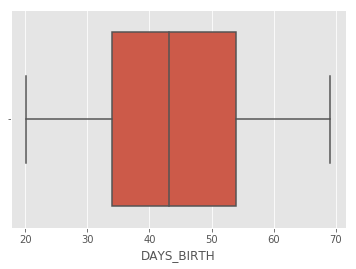

In [19]:
sns.boxplot(app['DAYS_BIRTH']/-365)
plt.show()

从输出的分位数结果和可视化的boxplot图来看，均没有发现异常值，因此DAYS_BIRTH应该是正常的。

再来看一下**DAYS_EMPLOYMENT**

In [20]:
app['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

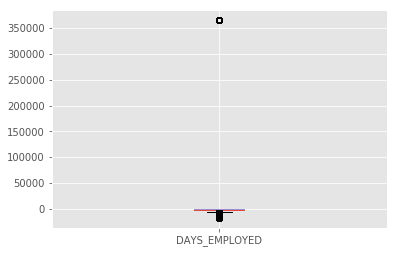

In [21]:
app['DAYS_EMPLOYED'].plot(kind='box')
plt.show()

DAYS_EMPLOYED看起来就不那么正常，最大值为365243天，而且是个正值，折算为年的单位就是1000年。再以hist图查看这个变量的统计分布。

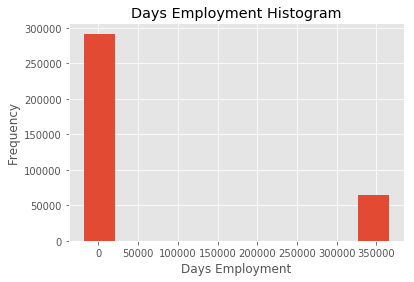

In [22]:
app['DAYS_EMPLOYED'].plot(kind='hist')
plt.title('Days Employment Histogram')
plt.xlabel('Days Employment')
plt.show()

面对异常值情况，不要首先就下判断删除，先要查看一下异常值情况对最终预测结果有什么影响

In [23]:
anom = app[app['DAYS_EMPLOYED']==365243]
non_anom = app[app['DAYS_EMPLOYED']!=365243]

In [24]:
print('The non-anomalies default on {:.2f}% of loans'.format(100 * non_anom['TARGET'].mean()))
print('The anomalies default on {:.2f}% of loans'.format(100 * anom['TARGET'].mean()))
print("There are {}({:.2f}%) anomalous days of employment".format(len(anom),100*len(anom)/len(app)))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 64648(18.15%) anomalous days of employment


我们发现一些有趣的结果。异常数据有着比非异常数据更低的违约率，是一个非常明显的差异。同时，异常数据一共有64648条（训练集和测试集的和），占总样本的18.15%，如果轻易将这些数据删除，对数据完整性是非常大的影响。因为我们手里也没有业务经验来判断这类异常是什么原因导致的，因此，一种比较靠谱的方法，我们考虑使用NaN缺失值来表示这类数据异常，之后再考虑如何进行填充。

定义一个新的特征，标记DAY_EMPLOYED这一列是否异常

In [25]:
app['DAYS_EMPLOYED_ANOM'] = (app['DAYS_EMPLOYED'] == 365243).map({False:0,True:1})

In [26]:
app['DAYS_EMPLOYED'] = app['DAYS_EMPLOYED'].apply(lambda x: np.nan if x == 365243 else x)

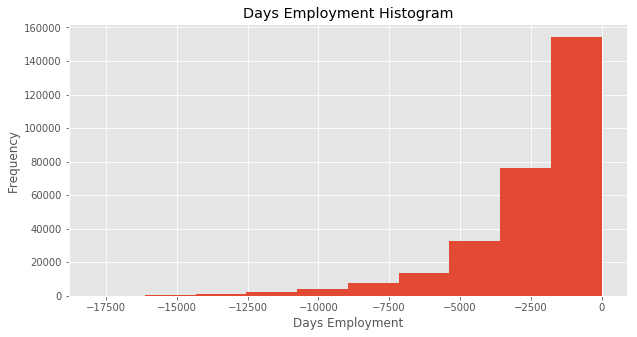

In [27]:
plt.figure(figsize=(10,5))
app['DAYS_EMPLOYED'].plot(kind='hist')
plt.title('Days Employment Histogram')
plt.xlabel('Days Employment')
plt.ylabel('Frequency')
plt.show()

上图所示的是我们期待见到的情况，工作时间越长的样本越少，明显的长尾。同时，我们还构造了一个新的特征，告诉模型在原始数据集中是异常的DAYS_EMPLOYD。

### 1.3特征之间的线性相关性

我们已经处理完了类别特征和异常值情况，我们继续探索分析的步骤。pandas中提供了一种简单的操作.corr来计算各列特征之间的线性相关性。一般的经验推荐，线性相关系数的绝对值大小反应了两列特征之间的线性相关程度：
* 0.00-0.2：非常弱相关
* 0.20-0.40：弱相关
* 0.40-0.60：中等相关
* 0.60-0.80：强相关
* 0.80-1.00：非常强相关

In [28]:
correlations = app.corr().sort_values('TARGET',ascending=False)

线性相关系数矩阵可视化

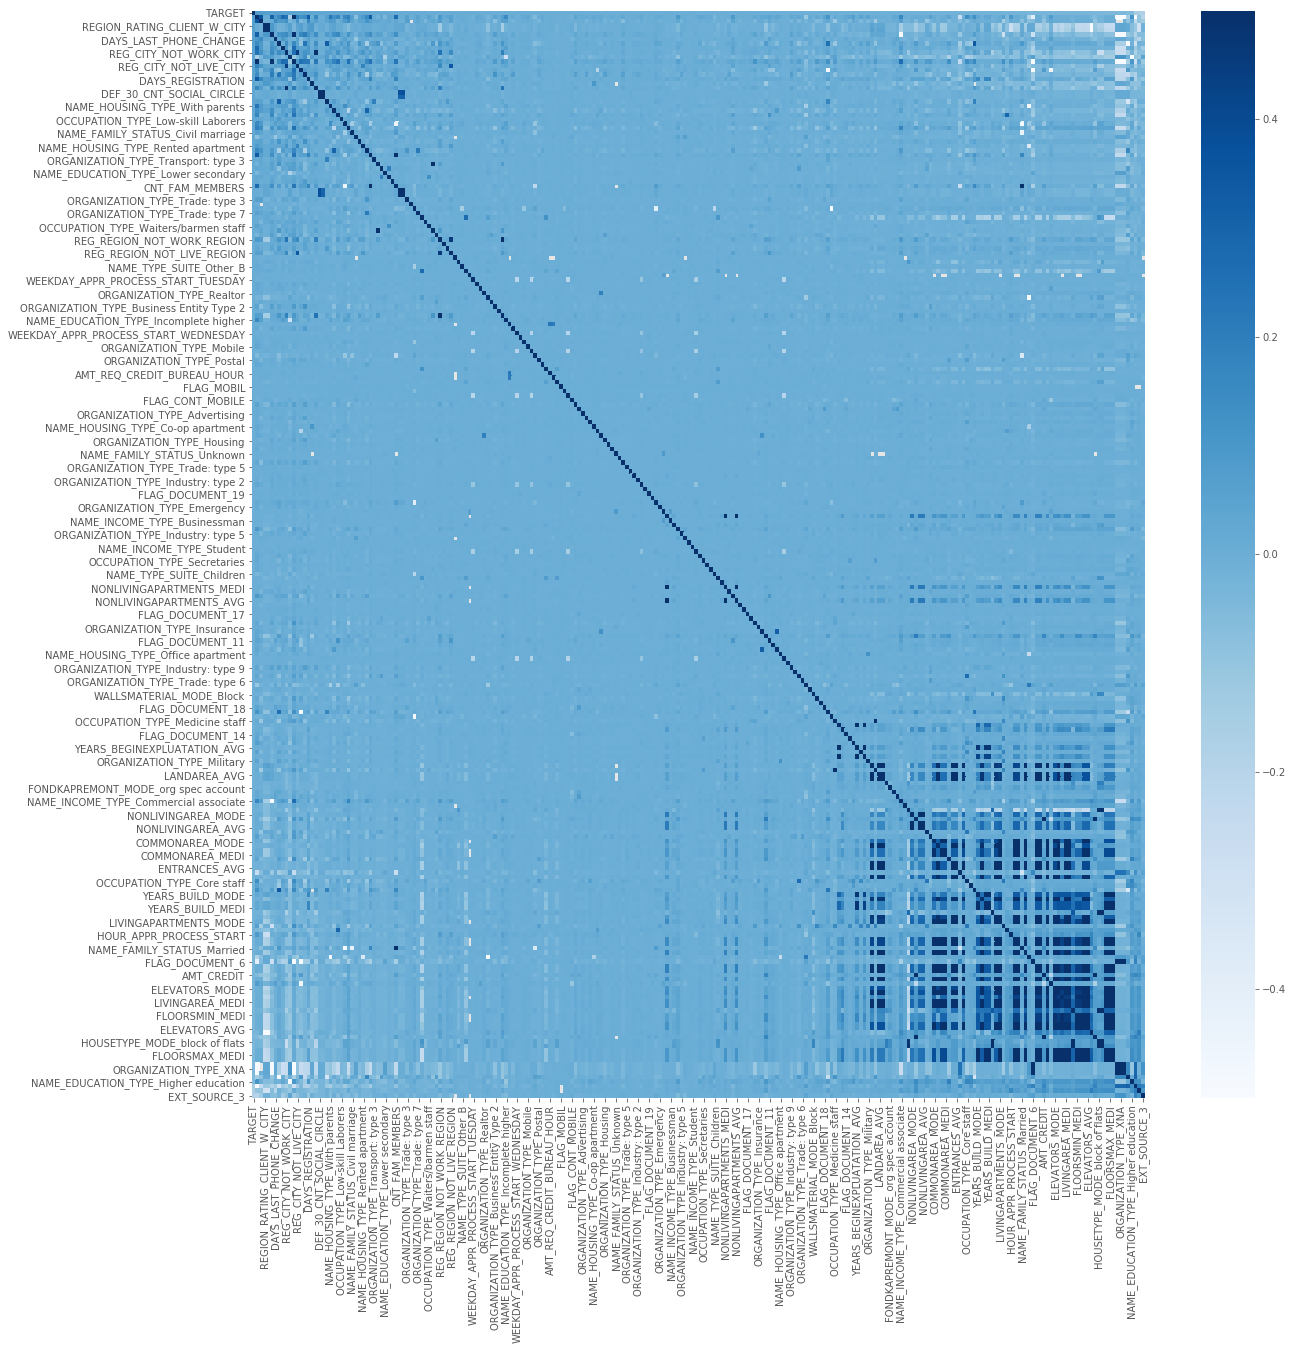

In [37]:
plt.figure(figsize=(20,20))
sns.heatmap(data=correlations.loc[correlations.index,correlations.index],cmap=plt.cm.Blues,vmax=0.5,vmin=-0.5)
plt.show()

左边纵坐标，由上向下，是线性相关系数由正变负逐渐减小的过程，首先我们发现，除了变量自相关等于1，其他特征与target特征相关性都不是很强，此外，在图的右下角，存在很多特征之间有较高的相关性。

In [38]:
corr_target = correlations['TARGET']

In [39]:
print('Most Positive Correlations: \n{}'.format(corr_target.head(15)))
print('Most Negative Correlations: \n{}'.format(corr_target.tail(15)))

Most Positive Correlations: 
TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
DAYS_EMPLOYED                                        0.074958
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
Name: TARGET, dtype: float64
Most Negativ

从输出结果中我们能够发现一些亮点：**DAYS_BIRTH**是最大正相关的特征，从官方提供的文档介绍，**DAYS_BIRTH**是用户的生日距离申请表填写日期的天数，因此是负值。因为该值本身为负，因此呈现的正相关性，实际上是负相关。也就是说，年龄越大的用户，违约率越低。我们看着有点晕，不如把这个数据转换为正值了再看。

In [40]:
app['DAYS_BIRTH'] = abs(app['DAYS_BIRTH'])
app['DAYS_BIRTH'].corr(app['TARGET'])

-0.07823930831003195

和我们在之前的判断是一直的，年龄和违约率是成负相关的，年龄越大的用户的违约风险越低。

我们来查看一下样本中用户的年龄分布情况

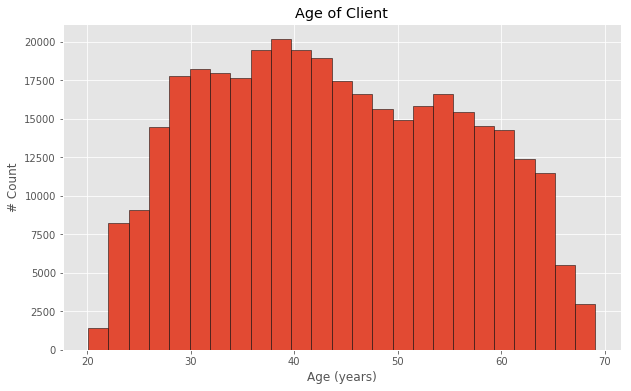

In [41]:
(app['DAYS_BIRTH']/365).plot(kind='hist',bins=25,edgecolor='black',figsize=(10,6))
plt.xlabel('Age (years)')
plt.ylabel('# Count')
plt.title('Age of Client')
plt.show()

我们再查看一下，违约用户和正常还款用户的年龄分布情况

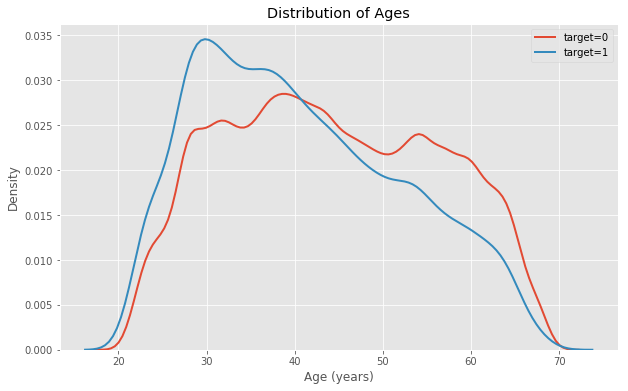

In [42]:
plt.figure(figsize=(10,6))
sns.kdeplot(app[app["TARGET"]==0]['DAYS_BIRTH']/365,linewidth=2,label='target=0')
sns.kdeplot(app[app["TARGET"]==1]['DAYS_BIRTH']/365,linewidth=2,label='target=1')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')
plt.legend()
plt.show()

target==1的曲线有年轻化的倾向，这个特征在之后进行机器学习建模的时候会派上用场。但是从上图概率密度曲线上看到趋势还是不那么直观，我们接下来，将DAYS_BIRTH这个变量进行切片分区，再重新可视化。

In [43]:
age_data = app[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

以5年为一个年龄段

In [44]:
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1.0,9461,25.920548,"(25.0, 30.0]"
1,0.0,16765,45.931507,"(45.0, 50.0]"
2,0.0,19046,52.180822,"(50.0, 55.0]"
3,0.0,19005,52.068493,"(50.0, 55.0]"
4,0.0,19932,54.608219,"(50.0, 55.0]"
5,0.0,16941,46.413699,"(45.0, 50.0]"
6,0.0,13778,37.747945,"(35.0, 40.0]"
7,0.0,18850,51.643836,"(50.0, 55.0]"
8,0.0,20099,55.065753,"(55.0, 60.0]"
9,0.0,14469,39.641096,"(35.0, 40.0]"


计算按年龄分组之后的各项的平均值

In [45]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
display(age_groups)

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8538.378305,23.392817
"(25.0, 30.0]",0.111436,10158.553439,27.831653
"(30.0, 35.0]",0.102814,11856.378412,32.483229
"(35.0, 40.0]",0.089414,13708.090633,37.556413
"(40.0, 45.0]",0.078491,15497.596332,42.459168
"(45.0, 50.0]",0.074171,17323.579317,47.461861
"(50.0, 55.0]",0.066968,19193.920120,52.586083
"(55.0, 60.0]",0.055314,20982.106594,57.485224
"(60.0, 65.0]",0.052737,22779.717434,62.410185


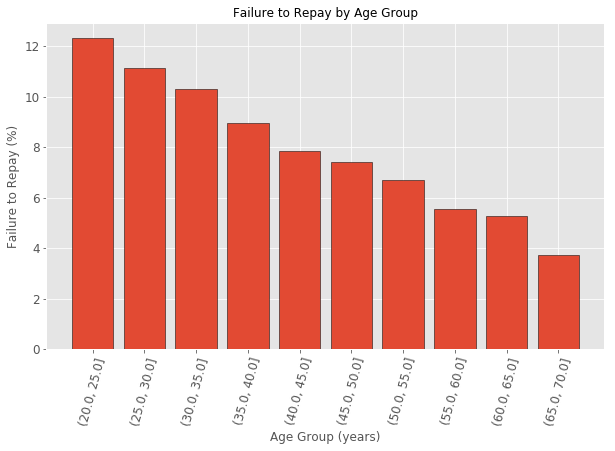

In [46]:
plt.figure(figsize=(10,6))
plt.bar(age_groups.index.astype(str),100*age_groups['TARGET'],edgecolor='black')
plt.xticks(rotation=75,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Age Group (years)',fontsize=12)
plt.ylabel('Failure to Repay (%)',fontsize=12)
plt.title('Failure to Repay by Age Group',fontsize=12)
plt.show()

这样分组之后，趋势就看的很清晰了，越年轻的用户的违约风险越高，最年轻的分组的平均违约风险为12%，年龄最大的分组的平均违约风险不到3%。

这个信息也是能够直接用于金融信贷公司的，通过这些明确的规则和信息，制定相应的信贷政策，来降低自身的业务坏账风险。当然，这并不是让机构不给年轻人提供信贷业务，而是提醒机构，在给年轻人提供信贷业务时，应当花更多的时间和精力去仔细评估客户的信用风险。

同样的，我们再分析一下正相关排名第二的特征DAYS_EMPLOYED

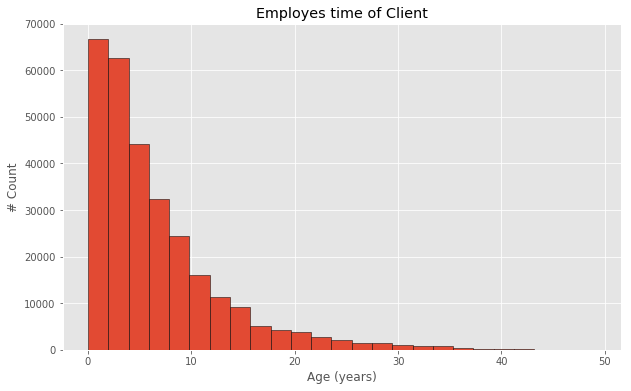

In [48]:
(app['DAYS_EMPLOYED']/-365).plot(kind='hist',bins=25,edgecolor='black',figsize=(10,6))
plt.xlabel('Age (years)')
plt.ylabel('# Count')
plt.title('Employes time of Client')
plt.show()

信贷申请者的工作年龄分布呈现长尾效应，工作时间越长的用户，提出贷款申请的人数就越少。

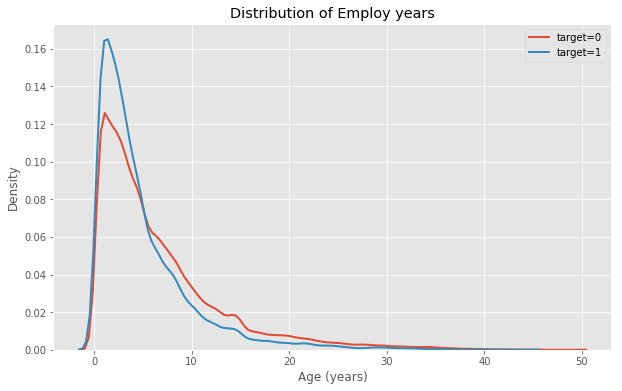

In [51]:
plt.figure(figsize=(10,6))
sns.kdeplot(app[app["TARGET"]==0]['DAYS_EMPLOYED']/-365,linewidth=2,label='target=0')
sns.kdeplot(app[app["TARGET"]==1]['DAYS_EMPLOYED']/-365,linewidth=2,label='target=1')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Employ years')
plt.legend()
plt.show()

In [59]:
age_data = app[['TARGET','DAYS_EMPLOYED']]
age_data['YEARS_EMPLOY'] = age_data['DAYS_EMPLOYED']/-365

In [61]:
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_EMPLOY'],bins=np.linspace(0,45,num=10))
age_data.head(10)

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOY,YEARS_BINNED
0,1.0,-637.0,1.745205,"(0.0, 5.0]"
1,0.0,-1188.0,3.254795,"(0.0, 5.0]"
2,0.0,-225.0,0.616438,"(0.0, 5.0]"
3,0.0,-3039.0,8.326027,"(5.0, 10.0]"
4,0.0,-3038.0,8.323288,"(5.0, 10.0]"
5,0.0,-1588.0,4.350685,"(0.0, 5.0]"
6,0.0,-3130.0,8.575342,"(5.0, 10.0]"
7,0.0,-449.0,1.230137,"(0.0, 5.0]"
8,0.0,NaN,NaN,NaN
9,0.0,-2019.0,5.531507,"(5.0, 10.0]"


In [62]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
display(age_groups)

,TARGET,DAYS_EMPLOYED,YEARS_EMPLOY
YEARS_BINNED,,,
"(0.0, 5.0]",0.105708,-868.721267,2.380058
"(5.0, 10.0]",0.073714,-2632.716141,7.212921
"(10.0, 15.0]",0.057752,-4463.271201,12.228140
"(15.0, 20.0]",0.048484,-6297.181287,17.252551
"(20.0, 25.0]",0.047573,-8094.639261,22.177094
"(25.0, 30.0]",0.039903,-9965.668583,27.303202
"(30.0, 35.0]",0.041258,-11789.557666,32.300158
"(35.0, 40.0]",0.019231,-13521.285253,37.044617
"(40.0, 45.0]",0.004762,-15323.155738,41.981249


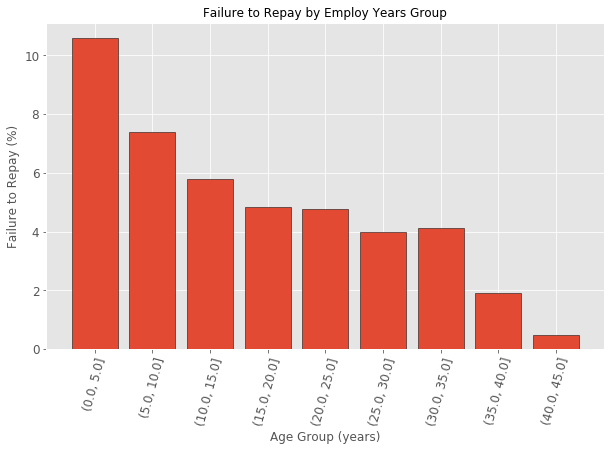

In [63]:
plt.figure(figsize=(10,6))
plt.bar(age_groups.index.astype(str),100*age_groups['TARGET'],edgecolor='black')
plt.xticks(rotation=75,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Age Group (years)',fontsize=12)
plt.ylabel('Failure to Repay (%)',fontsize=12)
plt.title('Failure to Repay by Employ Years Group',fontsize=12)
plt.show()

从上图，我们也可以清晰的看到，信贷申请者的工作年龄只有0-5年的，违约概率达到10%，随着申请者的工作年龄增长，违约率也不断下降。可以解释为，工作时间越长的用户，工作稳定，收入稳定，相比于工作时间比较短的申请者，因此不易出现违约情况。这也能称为信贷审核工作中可以关注的一个方面。

#### 外部信息Ext-Sources

除了DAYS_BIRTH外，还有3个最强的负相关特征，分别为：EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,官方并没有给出很细致的解释，总的理解来看，就是外部提供的一些数据的最终评分。

In [64]:
ext_data = app[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
display(ext_data_corrs)

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.212987,0.181390,0.586844
EXT_SOURCE_2,-0.160472,0.212987,1.000000,0.108480,0.095338
EXT_SOURCE_3,-0.178919,0.181390,0.108480,1.000000,0.201932
DAYS_BIRTH,-0.078239,0.586844,0.095338,0.201932,1.000000


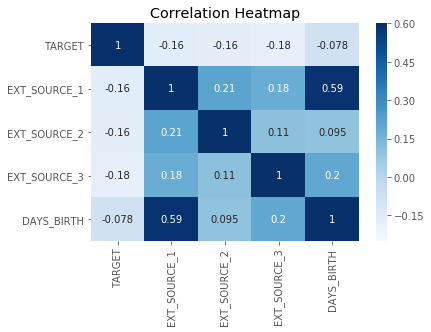

In [65]:
sns.heatmap(ext_data_corrs,annot=True,cmap=plt.cm.Blues,vmax=0.6,vmin=-0.25)
plt.title('Correlation Heatmap')
plt.show()

所有的三个EXT_SOURCE特征与Target特征都是负相关的。也就是说，这些值越大，违约风险就越低。
我们再来通过密度曲线观察，守信用户和违约用户在这些特征上的分布差异。

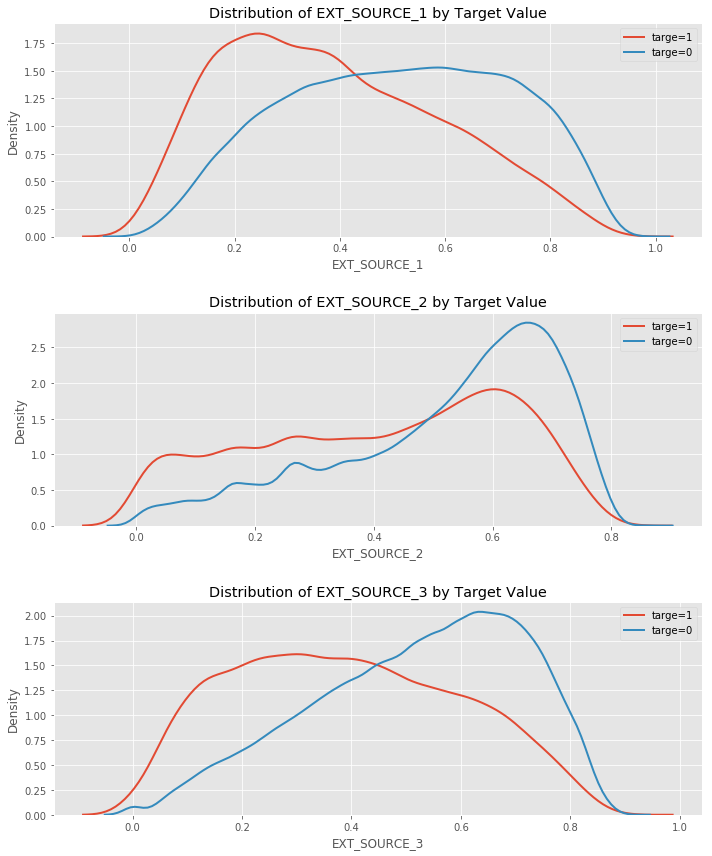

In [66]:
plt.figure(figsize=(10,12))
for i,source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3,1,i+1)
    sns.kdeplot(ext_data[ext_data['TARGET']==1][source],linewidth=2,label='targe=1')
    sns.kdeplot(ext_data[ext_data['TARGET']==0][source],linewidth=2,label='targe=0')
    plt.xlabel('{}'.format(source))
    plt.ylabel('Density')
    plt.title('Distribution of {} by Target Value'.format(source))
plt.tight_layout(h_pad=2.5)

EXT_SOURCE_3在不同的target取值时，表现出非常明显的差异。虽然从皮尔逊线性相关因子来看，与target的相关性不强，但是从图示的结果来看，实际上是一个非常强的预测特征（两个变量之间可能有强联系，但是如果不是线性关系，线性相关性因子也会比较小）。这些特征都将使用在后续机器学习建模，用于预测一个用户是否违约。

### 1.4特征工程Feature Engineering

Kaggle的竞赛者们大多都使用同样的boost模型（xgb，lgb），最终能够取胜通常是经过繁杂而富有创造性的构建非常有效的特征工程。而且大多数情况下，通过发现一个有效的特征获得的模型性能提升比专注于模型调参要高得多。富有经验的机器学习工作者也经常提到，特征工程决定了机器学习能够达到的高度，因此，在特征工程上多花些时间和精力，对于整个项目而言也是极其重要的。

特征工程往往由以下两个步骤组成：
* 由已知特征生成新的特征
* 特征选择

在这两个步骤中，会有很多的技术会用到。

在这里，我们仅使用两种简单的特征工程的方法：
* 多项式转换
* 专业领域知识

#### 1.4.1Polynomial Features多项式组合

In [67]:
poly_features = app[['EXT_SOURCE_1','EXT_SOURCE_2',
                     'EXT_SOURCE_3','DAYS_BIRTH','TARGET']]

In [68]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

In [69]:
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns=['TARGET'])

In [70]:
poly_features = imputer.fit_transform(poly_features)

In [71]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3,interaction_only=False,include_bias=False)

In [72]:
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)

In [73]:
print('Polynomial Features shape: {}'.format(poly_features.shape))

Polynomial Features shape: (356255, 34)


经过三次多项式特征转换之后，获得了包含30列特征的新数据。我们将新得到的数据的每列特征的名称打印出来。

In [74]:
poly_feature_names = poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
poly_feature_new = [feat for feat in poly_feature_names if feat not in 
                    ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','TARGET']]
print(len(poly_feature_new))
display(poly_feature_new)

30


['EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

随后，我们再来看看，新构造的特征与目标预测向量TARGET的相关性。

In [75]:
poly_features = pd.DataFrame(poly_features,columns=poly_feature_names)
poly_features = poly_features[poly_feature_new]

In [76]:
poly_features['TARGET'] = poly_target.values

In [80]:
poly_corrs = poly_features.corr().sort_values('TARGET',ascending=False)

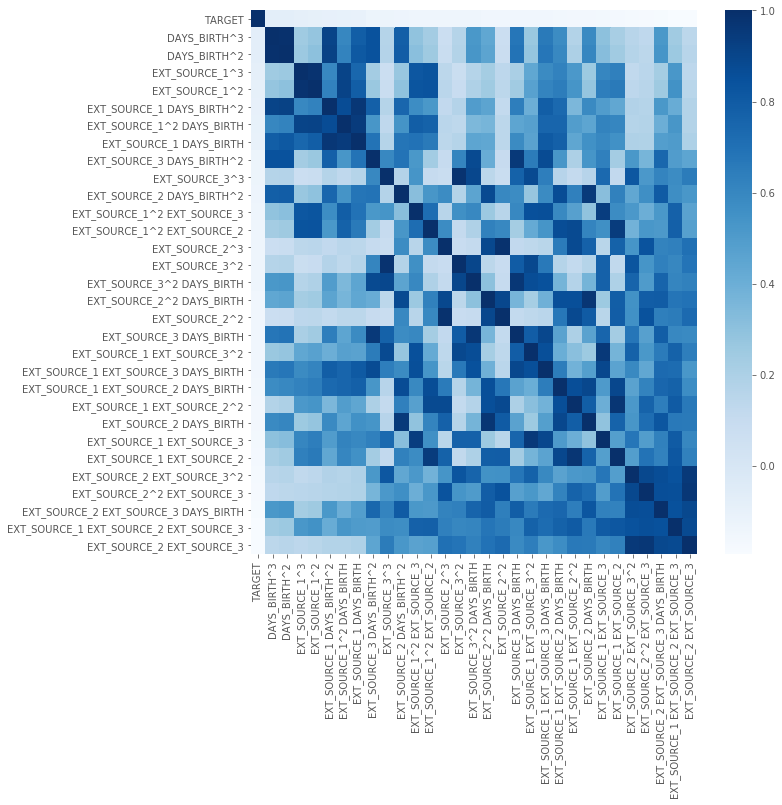

In [81]:
plt.figure(figsize=(10,10))
sns.heatmap(poly_corrs.loc[poly_corrs.index,poly_corrs.index],cmap=plt.cm.Blues)
plt.show()

从上图来看，新得到的特征与目标预测变量TARGET之间都是负相关的，此外，我们发现很多特征之间是有着高度的线性相关性的。

In [82]:
display(poly_corrs['TARGET'])

TARGET                                    1.000000
DAYS_BIRTH^3                             -0.074273
DAYS_BIRTH^2                             -0.076672
EXT_SOURCE_1^3                           -0.083006
EXT_SOURCE_1^2                           -0.091031
EXT_SOURCE_1 DAYS_BIRTH^2                -0.094908
EXT_SOURCE_1^2 DAYS_BIRTH                -0.097511
EXT_SOURCE_1 DAYS_BIRTH                  -0.104875
EXT_SOURCE_3 DAYS_BIRTH^2                -0.127002
EXT_SOURCE_3^3                           -0.128255
EXT_SOURCE_2 DAYS_BIRTH^2                -0.132839
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.138908
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.140205
EXT_SOURCE_2^3                           -0.140243
EXT_SOURCE_3^2                           -0.141744
EXT_SOURCE_3^2 DAYS_BIRTH                -0.141816
EXT_SOURCE_2^2 DAYS_BIRTH                -0.149313
EXT_SOURCE_2^2                           -0.149512
EXT_SOURCE_3 DAYS_BIRTH                  -0.150178
EXT_SOURCE_1 EXT_SOURCE_3^2    

从上述的相关性系数结果来看，我们通过三阶多项式组合的方式，得到了一些比原特征更高相关性的特征。

In [83]:
poly_features['SK_ID_CURR'] = app['SK_ID_CURR'].values

In [84]:
poly_features = poly_features.drop(columns=['TARGET'])

In [85]:
app = pd.merge(left=app,right=poly_features,on='SK_ID_CURR',how='left')

In [86]:
print(app.shape)

(356255, 274)


#### 1.4.2领域知识

我并不是什么信贷方面的业务专家，但是还是能利用有限的金融知识来理解此次竞赛的问题。我将构建一组特征试图来找到那些我们认为应该是比较重要的信息告诉我们那些用户可能会违约。

* CREDIT_INCOME_PERCENT: 贷款总额相比于贷款者收入的百分比；
* ANNUITY_INCOME_PERCENT: 贷款者的养老金相比于贷款者收入的百分比；
* CREDIT_TERM: 贷款者养老金相比于贷款者需还款的比值
* DAYS_EMPLOYED_PERCENT: 贷款者的工作时间相比于贷款者年龄的百分比

In [87]:
app['CREDIT_INCOME_PERCENT'] = app['AMT_CREDIT']/app['AMT_INCOME_TOTAL']
app['ANNUITY_INCOME_PERCENT'] = app['AMT_ANNUITY']/app['AMT_INCOME_TOTAL']
app['CREDIT_TERM'] = app['AMT_ANNUITY']/app['AMT_CREDIT']
app['DAYS_EMPLOYED_PERCENT'] = app['DAYS_EMPLOYED']/app['DAYS_BIRTH']

可视化刚刚构建的新特征

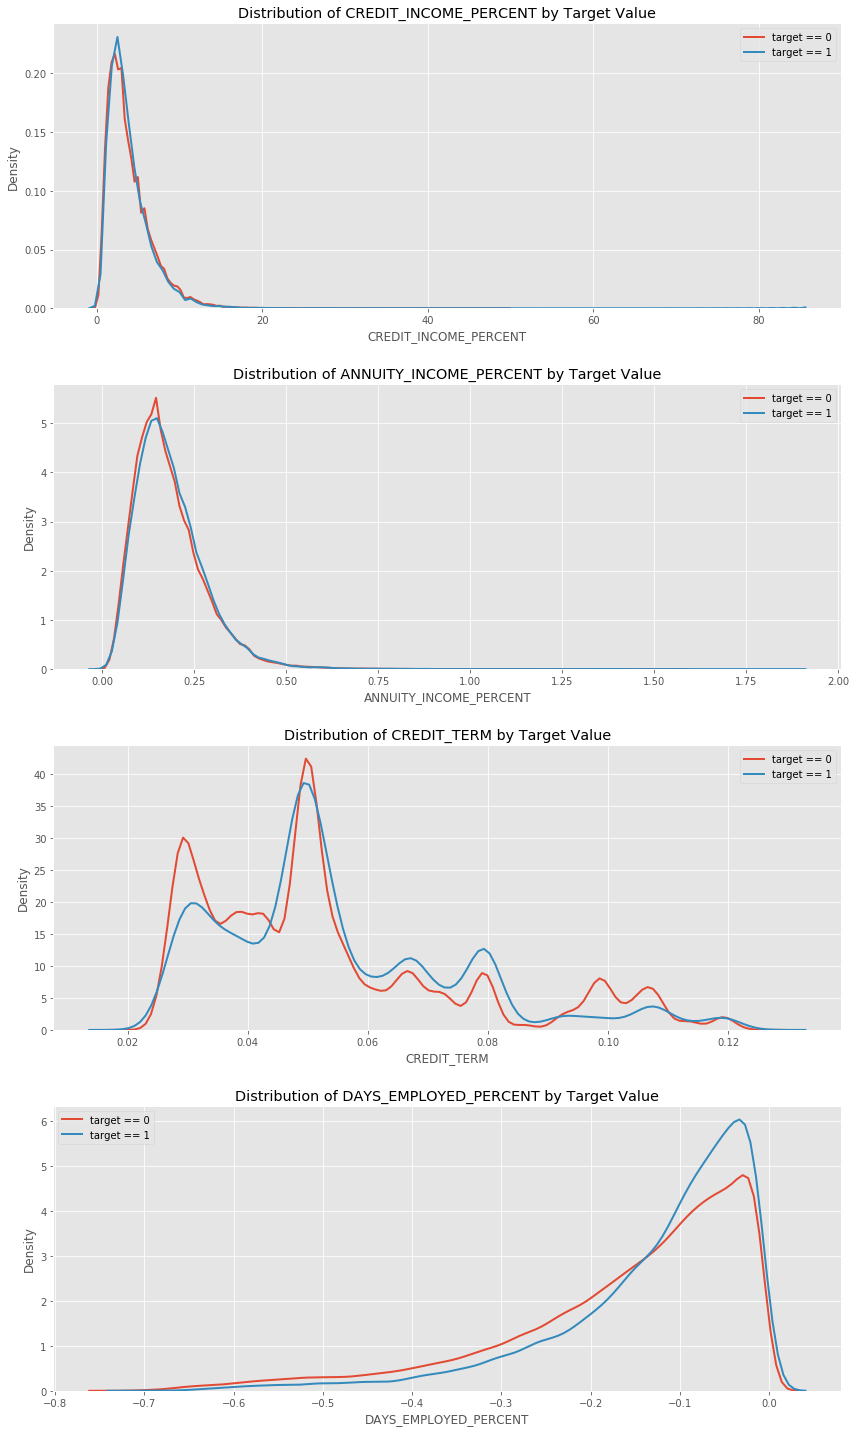

In [88]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app.loc[app['TARGET'] == 0, feature],linewidth=2, label = 'target == 0')
    sns.kdeplot(app.loc[app['TARGET'] == 1, feature],linewidth=2, label = 'target == 1')
    
    plt.title('Distribution of {} by Target Value'.format(feature))
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

从可视化的结果上看，很难说明我们基于领域知识刚刚构建的新特征有什么效果。只能看看在实际应用中的效果如何。

#### 1.4.3通过关联信息构造新特征

In [89]:
bureau = pd.read_csv("../data/bureau.csv").replace({365243:np.nan})
bureau_balance = pd.read_csv("../data/bureau_balance.csv").replace({365243:np.nan})

打印读取文件的大小

In [90]:
def return_size(df):
    return round(sys.getsizeof(df)/1e9,2)

将object属性的类别特征转换为pandas中特定的category数据类型，减少内存消耗

In [91]:
def convert_types(df):
    print(f"Original size of data: {return_size(df)} gb.")
    for c in df.columns:
        if df[c].dtype == 'object':
            df[c] = df[c].astype('category')
    print(f'New size of data: {return_size(df)} gb.')
    return df

In [92]:
bureau = convert_types(bureau)
bureau_balance = convert_types(bureau_balance)

Original size of data: 0.54 gb.
New size of data: 0.2 gb.
Original size of data: 2.13 gb.
New size of data: 0.46 gb.


bureau文件的占用空间从0.54G下降到0.2G，bureau_balance的占用空间从2.13G下降到0.46G，效果非常明显。

In [93]:
gc.collect()

30297

#### 1.4.3.1数据型特征聚合统计函数
将数据文件df中的数值特征，按照parent_var（这个是与父文件唯一对应的索引）进行分组，然后分别计算统计变量，例如mean和median。

In [94]:
def agg_numeric(df, parent_var, df_name):
    for col in df.columns:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns=col)
    
    parent_ids = df[parent_var]
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids
    
    agg = numeric_df.groupby(parent_var).agg(['count','mean','max','min','sum'])
    # 对新得到的统计变量重命名
    columns = []
    for var in agg.columns.levels[0]:
        if var != parent_var:
            for stat in agg.columns.levels[1]:
                columns.append('{}_{}_{}'.format(df_name,var,stat))
    agg.columns = columns
    _, idx = np.unique(agg,axis=1,return_index=True)
    agg = agg.iloc[:,idx]
    return agg

#### 1.4.3.2类别型特征聚合统计函数
对特定的category变量先进行onehot encoding，然后对编码之后的列按照parent_var进行分组，然后计算分组的统计值。

In [95]:
def agg_categorical(df, parent_var,df_name):
    categorical = pd.get_dummies(df.select_dtypes('category'))
    categorical[parent_var] = df[parent_var]
    categorical = categorical.groupby(parent_var).agg(['count','sum','mean'])
    columns = []
    for var in categorical.columns.levels[0]:
        for stat in categorical.columns.levels[1]:
            columns.append("{}_{}_{}".format(df_name,var,stat))
    # 重命名        
    categorical.columns = columns
    _,idx = np.unique(categorical,axis=1,return_index=True)
    categorical = categorical.iloc[:,idx]
    return categorical

#### 1.4.3.3一级子关联文件的聚合统计函数

In [96]:
def agg_child(df,parent_var,df_name):
    df_agg = agg_numeric(df,parent_var,df_name)
    df_agg_cat = agg_categorical(df,parent_var,df_name)
    
    df_info = df_agg.merge(df_agg_cat,on=parent_var,how='outer')
    # 列名查重
    _,idx = np.unique(df_info,axis=1,return_index=True)
    df_info = df_info.iloc[:,idx]
    
    gc.enable()
    del df_agg,df_agg_cat
    gc.collect()
    
    return df_info

#### 1.4.3.4 二级子关联文件的聚合统计函数

In [97]:
def agg_grandchild(df, parent_df,parent_var,grandparent_var,df_name):
    """
    在grandparent水平上聚合grandchild
    df: 基础文件夹，包含需要进行聚合处理的基础数据
    parent_df: 一级父文件，同时包含上一级子文件df索引parent_var和下一级
    父文件索引grandparent_var
    parent_var: df文件与一级父文件聚合时的索引
    grandparent_var: 一级父文件与二级父文件聚合时的索引
    df_name: 聚合结果重命名，最终结果为df_name+统计方法
    """
    # 为了实现更快的merge操作，将parent_var设置为索引index
    parent_df = parent_df[[parent_var,grandparent_var]].copy().set_index(parent_var)
    # df按照一级父文件的索引parent_var进行聚合
    df_agg = agg_numeric(df,parent_var,"{}_LOAN".format(df_name))
    # 将一级聚合解雇重塑到一级父问价中parent_df
    df_agg = df_agg.merge(parent_df,on=parent_var,how='left')
    # 将一级父文件按照二级父文件的索引grandparent_var聚合
    df_agg_client = agg_numeric(df_agg,grandparent_var,'{}_CLIENT'.format(df_name))
    
    if any(df.dtypes == 'category'):
        df_agg_cat = agg_categorical(df,parent_var,"{}_LOAN".format(df_name))
        df_agg_cat = df_agg_cat.merge(parent_df,on=parent_var,how='left')
        df_agg_cat_client = agg_numeric(df_agg_cat,grandparent_var,"{}_CLIENT".format(df_name))
        df_info = df_agg_client.merge(df_agg_cat_client,on=grandparent_var,how='outer')
        
        gc.enable()
        del df_agg, df_agg_client,df_agg_cat,df_agg_cat_client
        gc.collect()
        
    else:
        df_info = df_agg_client.copy()
        
        gc.enable()
        del df_agg, df_agg_client
        gc.collect()
    _, idx = np.unique(df_info, axis=1,return_index=True)
    df_info = df_info.iloc[:,idx]
    
    return df_info

#### 1.4.3.5手工构造特征（加减乘除）

In [98]:
app['LOAN_RATE'] = app['AMT_ANNUITY'] / app['AMT_CREDIT'] 
app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['EMPLOYED_BIRTH_RATIO'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']
app['EXT_SOURCE_SUM'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis = 1)
app['EXT_SOURCE_MEAN'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
app['AMT_REQ_SUM'] = app[[x for x in app.columns if 'AMT_REQ_' in x]].sum(axis = 1)

In [99]:
bureau['LOAN_RATE'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']

### 1.4.4 聚合bureau中的数据，包括数值变量和category变量，merge索引为SK_ID_CURR

In [100]:
bureau_info = agg_child(bureau, 'SK_ID_CURR', 'BUREAU')
display(bureau_info.head())

,BUREAU_DAYS_CREDIT_sum,BUREAU_DAYS_ENDDATE_FACT_sum,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_ENDDATE_min,BUREAU_DAYS_ENDDATE_FACT_min,BUREAU_DAYS_ENDDATE_FACT_mean,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_UPDATE_sum,BUREAU_DAYS_ENDDATE_FACT_max,BUREAU_DAYS_CREDIT_UPDATE_min,...,BUREAU_AMT_CREDIT_SUM_DEBT_mean,BUREAU_AMT_CREDIT_SUM_min,BUREAU_AMT_CREDIT_SUM_mean,BUREAU_AMT_CREDIT_SUM_DEBT_max,BUREAU_AMT_CREDIT_SUM_max,BUREAU_AMT_CREDIT_SUM_DEBT_sum,BUREAU_AMT_CREDIT_SUM_sum,BUREAU_AMT_CREDIT_MAX_OVERDUE_min,BUREAU_AMT_CREDIT_MAX_OVERDUE_mean,BUREAU_AMT_CREDIT_MAX_OVERDUE_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,-5145.0,-3302.0,-1572.0,-1329.0,-1328.0,-825.500000,-735.000000,-652.0,-544.0,-155.0,...,85240.928571,85500.0,207623.571429,373239.0,378000.0,596686.5,1453365.000,NaN,NaN,NaN
100002.0,-6992.0,-4185.0,-1437.0,-1072.0,-1185.0,-697.500000,-874.000000,-3999.0,-36.0,-1185.0,...,49156.200000,0.0,108131.945625,245781.0,450000.0,245781.0,865055.565,0.0,1681.029,5043.645
100003.0,-5603.0,-3292.0,-2586.0,-2434.0,-2131.0,-1097.333333,-1400.750000,-3264.0,-540.0,-2131.0,...,0.000000,22248.0,254350.125000,0.0,810000.0,0.0,1017400.500,0.0,0.000,0.000
100004.0,-1734.0,-1065.0,-1326.0,-595.0,-683.0,-532.500000,-867.000000,-1064.0,-382.0,-682.0,...,0.000000,94500.0,94518.900000,0.0,94537.8,0.0,189037.800,0.0,0.000,0.000
100005.0,-572.0,-123.0,-373.0,-128.0,-123.0,-123.000000,-190.666667,-163.0,-123.0,-121.0,...,189469.500000,29826.0,219042.000000,543087.0,568800.0,568408.5,657126.000,0.0,0.000,0.000


In [101]:
print(bureau_info.shape)

(305810, 107)


### 1.4.5聚合二级子文件bureau balance中的数据信息

In [102]:
bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [103]:
bureau_balance['PAST_DUE'] = (bureau_balance['STATUS'].isin(['1', '2', '3', '4', '5'])).astype(int)
bureau_balance['ON_TIME'] = (bureau_balance['STATUS'] == '0').astype(int)

In [104]:
bureau_balance_info = agg_grandchild(bureau_balance,bureau,'SK_ID_BUREAU','SK_ID_CURR','BB')

In [105]:
del bureau_balance,bureau
gc.collect()

63

In [106]:
display(bureau_balance_info.head())

,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_max,...,BB_CLIENT_BB_LOAN_STATUS_X_sum_max,BB_CLIENT_BB_LOAN_ON_TIME_sum_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean,BB_CLIENT_BB_LOAN_STATUS_X_sum_sum,BB_CLIENT_BB_LOAN_ON_TIME_sum_sum,BB_CLIENT_BB_LOAN_STATUS_C_sum_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_max,BB_CLIENT_BB_LOAN_STATUS_C_sum_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,-2800,-1326,-400.000000,-165,-82.5,-51,-25.5,-23.571429,-11.785714,-1,...,9,12,15.714286,24.571429,30.0,31,44,52,110.0,172
100002.0,-2701,-632,-337.625000,-226,-175.0,-47,-39.5,-28.250000,-21.875000,-6,...,3,18,2.875000,13.750000,15.0,45,13,22,23.0,110
100005.0,-91,-78,-30.333333,-18,-9.0,-12,-6.0,-6.000000,-3.000000,-3,...,1,7,1.666667,7.000000,2.0,14,5,13,5.0,21
100010.0,-3312,-2610,-1656.000000,-127,-92.0,-90,-72.5,-63.500000,-46.000000,-702,...,0,10,26.000000,36.000000,0.0,20,26,36,52.0,72
100013.0,-6756,-2346,-1689.000000,-226,-113.0,-68,-34.0,-56.500000,-28.250000,-780,...,40,34,25.750000,57.500000,41.0,79,44,69,103.0,230


In [107]:
print(bureau_balance_info.shape)

(134541, 109)


#### 与主数据表进行拼接
这里将SK_ID_CURR设置为index，会让聚合更加便利，效率也更高。

In [108]:
app = app.set_index('SK_ID_CURR')
app = app.merge(bureau_info,on='SK_ID_CURR',how='left')
del bureau_info
print(app.shape)

(356255, 390)


In [109]:
app = app.merge(bureau_balance_info,on='SK_ID_CURR',how='left')
del bureau_balance_info
print(app.shape)

(356255, 499)


### 1.4.6提取子关联表previous_application.csv中信息

In [110]:
previous = pd.read_csv('../data/previous_application.csv').replace({365243: np.nan})
previous = convert_types(previous)

Original size of data: 2.0 gb.
New size of data: 0.31 gb.


In [111]:
previous['LOAN_RATE'] = previous['AMT_ANNUITY'] / previous['AMT_CREDIT']
previous["AMT_DIFFERENCE"] = previous['AMT_CREDIT'] - previous['AMT_APPLICATION']

In [112]:
previous_info = agg_child(previous,'SK_ID_CURR','PREVIOUS')
print(previous_info.shape)

(338856, 382)


In [113]:
app = app.merge(previous_info,on='SK_ID_CURR',how='left')
del previous_info
print(app.shape)

(356255, 881)


In [114]:
gc.enable()
gc.collect()

42

In [115]:
app.to_csv("../data/all_engineered.csv",index=True,chunksize=10000)

#### 因为计算机内存的限制，剩下的3个二级子文件就不做演示。